In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

#loading the dataset
df_features = pd.read_csv('/content/features_3_sec.csv')

In [ ]:
variances = df_features.drop(columns=['label', 'filename']).var()
low_variance_columns = variances[variances < 1e-5].index
print("Columns with low variance:", low_variance_columns)

Columns with low variance: Index(['length', 'harmony_mean', 'perceptr_mean'], dtype='object')


In [ ]:
columns_to_drop = ['filename','length', 'harmony_mean', 'perceptr_mean']
for column in columns_to_drop:
    if column in df_features.columns:
        df_features = df_features.drop(columns=[column])

In [ ]:
print(df_features.columns)

Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_var', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var',
       'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean',
       'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var',
       'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean',
       'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var',
       'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean',
       'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var',
       'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean',
       'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label'],
      dtype='object')


In [ ]:
label_encoder = LabelEncoder()
df_features['label'] = label_encoder.fit_transform(df_features['label'])
X = df_features
y = df_features['label']

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
#standardizing the features (important for neural networks)
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

In [ ]:
#checking the total number of features
num_features=X_resampled.shape[1]
print(f"Number of Features: {num_features}")
num_classes=len(np.unique(df_features['label']))
print(f"Number of Genres: {num_classes}")

Number of Features: 56
Number of Genres: 10


In [ ]:
#apply PCA to reduce dimensionality to a manageable number
pca=PCA(n_components=num_features)

#PCA should be applied to 2D data, so reshape before applying PCA
X_resampled_2D=X_resampled.reshape(X_resampled.shape[0], -1)
X_resampled_pca=pca.fit_transform(X_resampled_2D)

#reshape after PCA
num_samples=X_resampled_pca.shape[0]
height=7
width=8
new_shape=(num_samples, height, width, 1)  #adjusted reshaped dimensions
X_resampled=X_resampled_pca.reshape(new_shape)

#one-hot encode the labels for categorical crossentropy loss
_, y_resampled=smote.fit_resample(df_features.drop(columns=['label']), df_features['label'])
print("Restored y_resampled shape:", y_resampled.shape)

#one-hot encode
y_resampled = to_categorical(y_resampled, num_classes=num_classes)
print("One-hot encoded y_resampled shape:", y_resampled.shape)  # Should be (10000, 10)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

Restored y_resampled shape: (10000,)
One-hot encoded y_resampled shape: (10000, 10)
X_resampled shape: (10000, 7, 8, 1)
y_resampled shape: (10000, 10)


In [ ]:
#split into train and test sets in ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8000, 7, 8, 1)
y_train shape: (8000, 10)
X_test shape: (2000, 7, 8, 1)
y_test shape: (2000, 10)


In [ ]:
#CNN model
model=Sequential()
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(7,8,1), padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model training
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
#model evaluation
test_loss, test_accuracy=model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2723 - loss: 2.0336 - val_accuracy: 0.5356 - val_loss: 1.3785
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5342 - loss: 1.3207 - val_accuracy: 0.6656 - val_loss: 0.9825
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6772 - loss: 0.9474 - val_accuracy: 0.7656 - val_loss: 0.7129
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7526 - loss: 0.7294 - val_accuracy: 0.8100 - val_loss: 0.5649
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7870 - loss: 0.6118 - val_accuracy: 0.8425 - val_loss: 0.4800
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8208 - loss: 0.4932 - val_accuracy: 0.8444 - val_loss: 0.4344
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8623 - loss: 0.4193 - val_accuracy: 0.8594 - val_loss: 0.3918
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8665 - loss: 0.3836 - val_accuracy: 0.

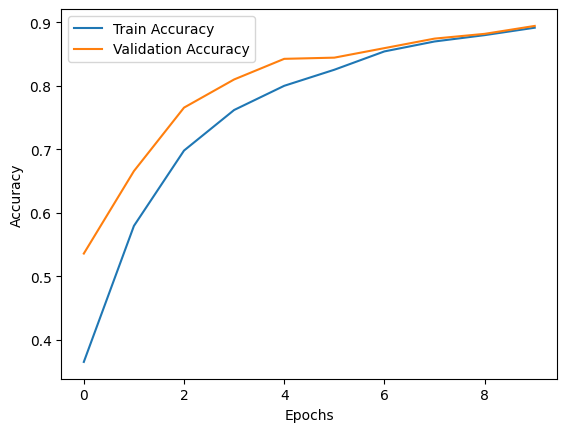

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
#accuracy vs loss plots on training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred=model.predict(X_test)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       208
           1       0.92      0.98      0.95       202
           2       0.89      0.81      0.85       191
           3       0.86      0.78      0.82       202
           4       0.88      0.81      0.84       208
           5       0.85      0.97      0.91       187
           6       0.97      0.98      0.97       211
           7       0.92      0.89      0.90       205
           8       0.87      0.88      0.87       211
           9       0.95      0.90      0.92       175

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



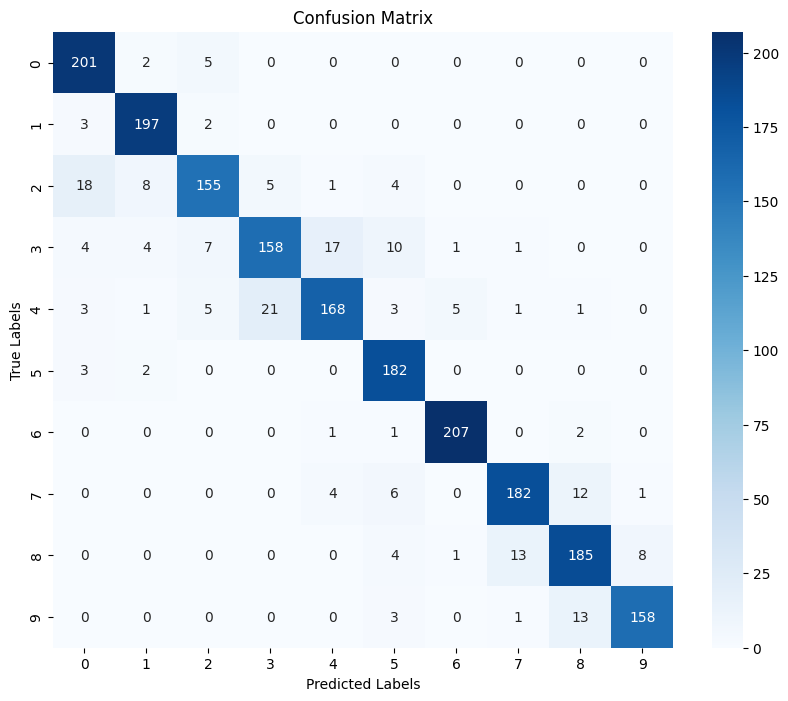

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred=model.predict(X_test)
y_pred_classes=np.argmax(y_pred, axis=1)
y_true=np.argmax(y_test, axis=1)

#classification report
print(classification_report(y_true, y_pred_classes))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

#confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()